## `statemodify` Quickstarter Notebook #3 : Using the RES Modification Function in the Upper Colorado River Basin

This notebook demonstrates the reservoir storage modification function in the Upper Colorado River Basin. In this notebook, we seek to understand how changes to reservoir storage can impact user shortages. First we run a baseline simulation, which runs the StateMod simulation assuming that the current infrastructure has existed through the whole simulation period. We next extract shortages for a municipality. Recall that the list of users and their water rights can be found in the `.ddr` file (located: `data/cm2015_StateMod/StateMod/cm2015.ddr`)

### Step 1: Run a Historical Simulation in StateMod for the Uppper Colorado Subbasin

In [1]:
import argparse
import logging
import os
import pickle
from string import Template
import subprocess

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import statemodify as stm

<div class="alert alert-block alert-info"> 
    
<b>NOTE</b>: Each simulation in this notebook is run for the length of the historical period (from 1909-2013). If you want to reduce the length of the simulation, navigate to the `.ctl` file and adjust the `iystr` and `iyend` variables. For this notebook, this file is located in: `data/cm2015_StateMod/StateMod/cm2015.ctl` 

</div>

As before, we set the directories and associated paths and also run StateMod in a baseline simulation.

In [2]:
# statemod directory
statemod_dir = "/usr/src/statemodify/statemod_upper_co"

# root directory of statemod data for the target basin
root_dir = os.path.join(statemod_dir, "src", "main", "fortran")

# home directory of notebook instance
home_dir = os.path.dirname(os.getcwd())

# path to the statemod executable
statemod_exe = os.path.join(root_dir, "statemod")

# data directory and root name for the target basin
data_dir = os.path.join(
    home_dir,
    "data",
    "cm2015_StateMod",
    "StateMod"
)

# directory to the target basin input files with root name for the basin
basin_path = os.path.join(data_dir, "cm2015B")

# scenarios output directory
scenarios_dir_res = os.path.join(data_dir, "scenarios_res")

# parquet files output directory
parquet_dir_res = os.path.join(data_dir, "parquet_res")


# path to res template file
res_template_file = os.path.join(
    home_dir,
    "data",
    "cm2015B_template_res.rsp"
)

<div class="alert alert-block alert-info"> 
    
<b>NOTE</b> In order to expedite simulations for the Upper Colorado dataset, make sure to turn off "Reoperation" mode. You can do so by opening `/home/jovyan/data/cm2015_StateMod/StateMod/cm2015.ctl`, navigating to the `ireopx` entry and changing the value from "0" to "10".  

</div>

In [3]:
# Change directories first 
os.chdir(data_dir) #This is needed specific to the Upper Colorado model as the path name is too long for the model to accept
subprocess.call([statemod_exe, "cm2015B", "-simulate"])


  Parse; Command line argument: 
  cm2015B -simulate                                                                                                              
________________________________________________________________________

        StateMod                       
        State of Colorado - Water Supply Planning Model     

        Version: 15.00.01
        Last revision date: 2015/10/28

________________________________________________________________________

  Opening log file cm2015B.log                                                                                                                                                                                                                                                     
  
  Subroutine Execut
  Subroutine Datinp

________________________________________________________________________
  Datinp; Control File (*.ctl) 

________________________________________________________________________
  Datinp; River Networ

0

We isolate the shortages for one municipal user: the Town of Brekenridge at the base of the Rocky Mountains’ Tenmile Range (ID: 3601008). If we look up this user in the `cm2015B.ddr` file, we see that the user has median water rights (47483.00000) and a smaller decree of 2.90 cfs. 

In [4]:
#Extract shortages using statemodify convert_xdd() function  

# create a directory to store the historic shortages 
output_dir = os.path.join(data_dir, "historic_shortages")

# create a directory to store the new files in if it does not exist
output_directory = os.path.join(data_dir, "historic_shortages")
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

stm.xdd.convert_xdd(
    # path to a directory where output .parquet files should be written
    output_path=output_dir,
    # whether to abort if .parquet files already exist at the output_path
    allow_overwrite=True,
    # path, glob, or a list of paths/globs to the .xdd files you want to convert
    xdd_files=os.path.join(data_dir, "*.xdd"),
    # if the output .parquet files should only contain a subset of structure ids, list them here; None for all
    id_subset=['3601008'],
    # how many .xdd files to convert in parallel; optimally you will want 2-4 CPUs per parallel process
    parallel_jobs=2,
    # convert to natural data types
    preserve_string_dtype=False
    
)

100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Next we plot the shortages for Breckenridge.

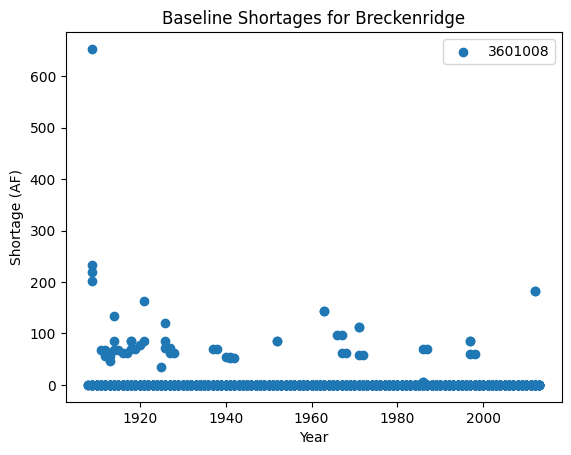

In [5]:
data=pd.read_parquet(output_dir +'/cm2015B.parquet',engine='pyarrow')

fig, ax = plt.subplots()

for name, group in data.groupby('structure_id'):
    ax.scatter(
        group['year'], group['shortage_total'], label=name)

plt.xlabel("Year")
plt.ylabel("Shortage (AF)")
plt.title("Baseline Shortages for Breckenridge")
plt.legend()

We see that Breckenridge has experienced a variety of shortages throughout the baseline simulation period.

### Step 2: Modify StateMod Input Files for Exploratory Analyses- Reservoir Function Example

If we look at the `cm2015B.res` file (learn more about the [`.res`](https://opencdss.state.co.us/statemod/latest/doc-user/InputDescription/411/)file), we see that Breckenridge has an account in the Clinton Gulch Reservoir, but a quick look in the [`.opr`](https://opencdss.state.co.us/statemod/latest/doc-user/InputDescription/413/) file also indicates that Breckenridge can receive water from the Dillon reservoir. Let’s investigate what happens to these shortages when storage at these two basins decreases using the `modify_res()` function. As done in Hadjimichael et al. (2020), we sample losses using a Latin hypercube sampling of up to 20% of the capacity of the reservoirs (informed by Graf et al. (2010)) which may be due to erosion and sedimentation of reservoirs in the UCRB, resulting in reduced storage. The accounts associated with the reservoirs are also reduced equally in order to accommodate the new storage level. For this example, we want to change the reservoir storage for a specific set of reservoirs by specifying the reservoir IDs for the `target_structure_id_list`. However, by setting `target_structure_id_list=None` we can decrease storage at all reservoirs in the basin.

In [6]:
output_directory = output_dir = os.path.join(data_dir, "input_files")
scenario = "1"
# basin name to process
basin_name = "Upper_Colorado"

# seed value for reproducibility if so desired
seed_value = 1

# number of jobs to launch in parallel; -1 is all but 1 processor used
n_jobs = 2

# number of samples to generate
n_samples = 1

stm.modify_res(output_dir=output_directory,
               scenario=scenario,
               basin_name=basin_name,
               target_structure_id_list=['3603575','3604512'],
               seed_value=seed_value,
               n_jobs=n_jobs,
               n_samples=n_samples,
               save_sample=True)


Since we are sampling only reductions in storage, we can investigate behavior with a single sample. We can then load the saved sample to see the percent reduction in reservoir storage volume that has been applied to the different reservoirs. The sample indicates that we are reducing the reservoir storage volume to 86% of the original storage.

In [7]:
import numpy as np
sample_array = np.load(output_directory+'/res_1-samples_scenario-1.npy')
sample_array

array([0.86911215])

### Step 3: Read in the New Input Files and Run StateMod : Reservoir Example

Now that we have created the input files, the next step is to run StateMod with the new input files. We create a template `.rsp` file (`cm2015B_template_res.rsp`) and swap in the path to the alternative `.res` files that are created. Then we run StateMod for the two scenarios and extract the shortages for Breckenridge.

In [8]:
# set realization and sample
realization = 1
sample = np.arange(0, 2, 1)

# read RSP template
with open(res_template_file) as template_obj:
    
    # read in file
    template_rsp = Template(template_obj.read())

    for i in sample:
        
        # create scenario name
        scenario = f"S{i}_{realization}"
        
        # dictionary holding search keys and replacement values to update the template file
        d = {"RES": f"../../input_files/cm2015B_{scenario}.res"}
        
        # update the template
        new_rsp = template_rsp.safe_substitute(d)
        
        # construct simulated scenario directory
        simulated_scenario_dir = os.path.join(scenarios_dir_res, scenario)
        if not os.path.exists(simulated_scenario_dir):
            os.makedirs(simulated_scenario_dir)
            
        # target rsp file
        rsp_file = os.path.join(simulated_scenario_dir, f"cm2015B_{scenario}.rsp")
        
        # write updated rsp file
        with open(rsp_file, "w") as f1:
            f1.write(new_rsp)
        
        # construct simulated basin path
        simulated_basin_path = f"cm2015B_{scenario}"

        # run StateMod
        print(f"Running: {scenario}")
        os.chdir(simulated_scenario_dir)

        subprocess.call([statemod_exe, simulated_basin_path, "-simulate"])
        
        #Save output to parquet files 
        print('creating parquet for ' + scenario)
        
        output_directory = os.path.join(parquet_dir_res+"/scenario/"+ scenario)
        
        if not os.path.exists(output_directory):
            os.makedirs(output_directory)
        
        stm.xdd.convert_xdd(
            output_path=output_directory,
            allow_overwrite=True,
            xdd_files=scenarios_dir_res + "/"+ scenario + "/cm2015B_"+scenario+".xdd",
            id_subset=['3601008'],
            parallel_jobs=2,
            preserve_string_dtype=False
        )

Running: S0_1
  Parse; Command line argument: 
  cm2015B_S0_1 -simulate                                                                                                         
________________________________________________________________________

        StateMod                       
        State of Colorado - Water Supply Planning Model     

        Version: 15.00.01
        Last revision date: 2015/10/28

________________________________________________________________________

  Opening log file cm2015B_S0_1.log                                                                                                                                                                                                                                                
  
  Subroutine Execut
  Subroutine Datinp

________________________________________________________________________
  Datinp; Control File (*.ctl) 

________________________________________________________________________
  Datinp

100%|██████████| 1/1 [00:00<00:00, 586.29it/s]


Running: S1_1
  Parse; Command line argument: 
  cm2015B_S1_1 -simulate                                                                                                         
________________________________________________________________________

        StateMod                       
        State of Colorado - Water Supply Planning Model     

        Version: 15.00.01
        Last revision date: 2015/10/28

________________________________________________________________________

  Opening log file cm2015B_S1_1.log                                                                                                                                                                                                                                                
  
  Subroutine Execut
  Subroutine Datinp

________________________________________________________________________
  Datinp; Control File (*.ctl) 

________________________________________________________________________
  Datinp

100%|██████████| 1/1 [00:00<00:00, 589.42it/s]


Here, we extract the shortages from the Parquet files for the baseline and alternative states of the world and plot the resulting shortages.

In [10]:
baseline=pd.read_parquet(data_dir+'/'+'historic_shortages/cm2015B.parquet',engine='pyarrow')
SOW_1=pd.read_parquet(parquet_dir_res+'/scenario/S0_1/cm2015B_S0_1.parquet',engine='pyarrow')


In [19]:
baseline["shortage_total"]

283920      0.
283921      0.
283922      0.
283923    220.
283924    201.
          ... 
285280      0.
285281      0.
285282      0.
285283      0.
285284      0.
Name: shortage_total, Length: 1365, dtype: object

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


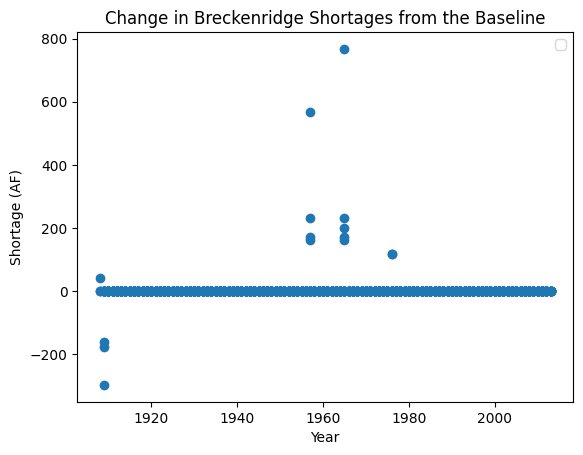

In [9]:
baseline=pd.read_parquet(data_dir+'/'+'historic_shortages/cm2015B.parquet',engine='pyarrow')
SOW_1=pd.read_parquet(parquet_dir_res+'/scenario/S0_1/cm2015B_S0_1.parquet',engine='pyarrow')

#Subtract shortages with respect to the baseline
subset_df=pd.concat([baseline['year'],baseline['shortage_total'],SOW_1['shortage_total']],axis=1)
subset_df = subset_df.set_axis(['Year', 'Baseline', 'SOW_1'], axis=1)
subset_df['SOW_1_diff']=subset_df['SOW_1']-subset_df['Baseline']

#Plot shortages
fig, ax = plt.subplots()

ax.scatter(subset_df['Year'], subset_df['SOW_1_diff'])

plt.xlabel("Year")
plt.ylabel("Shortage (AF)")
plt.title("Change in Breckenridge Shortages from the Baseline")
plt.legend()

When we plot the shortages to Breckenridge under the alternative SOW where reservoir storage is reduced across the two reservoirs, we can see that there are now instances in which Breckenridge experiences larger shortages than in the baseline case. Given that the town utilizes both direct diversions and reservoir storage for water supply, this result suggests that they have less of a bank of water to pull from in the two reservoirs which increases shortages. However, there are even some cases where the town experiences surpluses and many cases where the shortages do not change, demonstrating that there is inherent complexity in the mapping of reservoir level to shortages, especially when the user has multiple reservoir accounts. 

Now continue on to Quickstarter Notebook #4 to learn about running StateMod with new streamflow scenarios across the West Slope basins.

### References

Graf, W. L., Wohl, E., Sinha, T., & Sabo, J. L. (2010). Sedimentation and sustainability of western American reservoirs. Water Resources Research, 46, W12535. https://doi.org/10.1029/2009WR008836


Hadjimichael, A., Quinn, J., Wilson, E., Reed, P., Basdekas, L., Yates, D., & Garrison, M. (2020). Defining robustness, vulnerabilities, and consequential scenarios for diverse stakeholder interests in institutionally complex river basins. Earth's Future, 8(7), e2020EF001503.


<div class="alert alert-block alert-warning"> 
    
<b>Tip:</b> If you are interested in understanding how to apply `statemodify` functions to your own model, take a look at the source code found in the repository here:   
    
    
<div>
    1.  <a href="https://github.com/IMMM-SFA/statemodify/blob/main/statemodify/res.py">modify_res()</a>

</div>  
  

</div>
